# Coagulation Patterns: Particle-Resolved Approach

In this notebook, we explore coagulation patterns through a particle-resolved approach. Rather than directly invoking coagulation functions for each calculation, we adopt a more modular and object-oriented programming structure. By employing design patterns, such as the `Builder` pattern, we simplify the setup and validation of parameters, making the process more maintainable and scalable.

This approach allows for the efficient management of both the gas phase and the particle distribution, incorporating the verification of input parameters for accuracy and consistency. The `Builder` classes facilitate setting up the coagulation environment, from defining the atmospheric conditions to creating particle distributions and specifying their resolved masses.

In this example, we preset a non-condensing gas species in the atmosphere and use a lognormal distribution for particles. We represent the particles using a particle-resolved mass framework, where we handle properties like density, charge, and mass with strategies to define the activity, surface area, and distribution.

**Imports**

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# particula imports
from particula.next import particles
from particula.next.aerosol import Aerosol

from particula.next.gas.species_builders import PresetGasSpeciesBuilder
from particula.next.gas.atmosphere_builders import AtmosphereBuilder

from particula.next.dynamics import particle_process
from particula.next.dynamics import coagulation

## Aerosol Setup

In this section, we define the core components of our particle-resolved coagulation system, focusing on the atmosphere setup, particle distribution, and mass resolution. This step-by-step breakdown helps clarify how the `Builder` pattern organizes the construction of complex objects and ensures input parameters are properly verified.

**Atmospheric Setup**
We begin by configuring the atmosphere using the `AtmosphereBuilder`. This allows for flexibility in defining environmental parameters such as temperature and pressure, as well as adding gas species. In this case, we add a preset gas species that does not condense and set the atmospheric conditions to 25°C and 1 atm.

**Particle Distribution**
The particle distribution is generated using a lognormal distribution, a common approach for representing aerosol particle sizes. The parameters for this distribution include:
- A mode of 100 nm, representing the mean particle diameter.
- A geometric standard deviation (GSD) of 1.3, which controls the spread of particle sizes.
- The total number of particles is 100,000 samples taken to capture the variability of the distribution.

**Mass Calculation**
The mass of each particle is calculated assuming a particle density of 1500 kg/m³. This density corresponds to typical aerosol materials like dust or certain types of particulate matter. The particle masses are computed using the formula for the volume of a sphere, multiplied by the density.

**Resolved Particle Mass Representation**
To capture the diversity of the aerosol population, we use a particle-resolved representation for mass. This approach explicitly tracks individual particle masses and assigns properties such as density and charge. The key strategies used are:
- **Distribution strategy**: Defines how mass is distributed among particles.
- **Activity strategy**: Describes how the activity of the particles is represented, in this case, assuming ideal mass behavior.
- **Surface strategy**: Calculates particle surface behavior by volume mixing.

**Final Aerosol Object**
The `Aerosol` object brings together the atmosphere and the resolved particle masses into a cohesive framework. This encapsulated representation can then be used to simulate particle interactions and coagulation events within the atmosphere.

Finally, we print the properties of the `aerosol` object’s atmosphere to verify the correct setup.

In [2]:
# Preset gas species that does not condense in the atmosphere
# AtmosphereBuilder constructs the atmosphere with predefined species
atmosphere = (
    AtmosphereBuilder()
    .add_species(PresetGasSpeciesBuilder().build())  # Add a preset gas species
    .set_temperature(25, temperature_units="degC")  # Set temperature to 25°C
    .set_pressure(1, pressure_units="atm")  # Set pressure to 1 atmosphere
    .build()  # Finalize the atmosphere object
)

# Generate a particle distribution using a lognormal sample distribution
# This distribution has a mean particle diameter (mode) and geometric standard deviation (GSD)
particle_sample = particles.properties.lognormal_sample_distribution(
    mode=np.array([100e-9]),  # Mean particle diameter of 100 nm
    geometric_standard_deviation=np.array([1.3]),  # GSD of 1.3
    number_of_particles=np.array([1e4]),  # Total number of particles
    number_of_samples=100_000,  # Number of samples for particle distribution
)

# Calculate the mass of each particle in the sample, assuming density of 1500 kg/m^3
particle_mass_sample = (
    4 / 3 * np.pi * particle_sample**3 * 1500
)  # Particle mass in kg

# Build a resolved mass representation for each particle
# This defines how particle mass, activity, and surface are represented
resolved_masses = (
    particles.ResolvedParticleMassRepresentationBuilder()
    .set_distribution_strategy(particles.ParticleResolvedSpeciatedMass())  # Use speciated mass distribution
    .set_activity_strategy(particles.ActivityIdealMass())  # Define activity based on ideal mass
    .set_surface_strategy(particles.SurfaceStrategyVolume())  # Define surface area based on particle volume
    .set_mass(particle_mass_sample, "kg")  # Assign mass of particles (in kg)
    .set_density(1500, "kg/m^3")  # Set particle density to 1500 kg/m^3
    .set_charge(0)  # Assume neutral particles with no charge
    .set_volume(0.1, "cm^3")  # Set volume of particle distribution
    .build()  # Finalize the resolved mass representation
)

# Create an aerosol object with the defined atmosphere and resolved particles
aerosol = Aerosol(atmosphere=atmosphere, particles=resolved_masses)

# Print the properties of the atmosphere
print(aerosol)

Gas mixture at 298.15 K and 101325.0 Pa consisting of ['Preset100']
[0]: Particle Representation (strategy=ParticleResolvedSpeciatedMass, activity=ActivityIdealMass, surface=SurfaceStrategyVolume, total mass=8.599074007698883e-13) 


## Simulation

In this section, we run the coagulation simulation by first defining the coagulation strategy and the process through which it is executed.

- **Coagulation Strategy:** The strategy for how coagulation is performed is selected using `coagulation.ParticleResolved()`. This specific strategy dictates how particle interactions are handled at the individual particle level, ensuring that the coagulation process respects the details of a particle-resolved approach. In this context, particles are treated as distinct entities, and the merging process is computed explicitly for each pair that interacts.

- **Particle Process:** Once the strategy is defined, the `Coagulation` process is initialized by passing the chosen strategy (`coagulation_strategy`) to the `particle_process.Coagulation` class. This `Coagulation` class is responsible for running the actual simulation. It orchestrates the execution of coagulation by applying the selected strategy over the particle distribution. During each execution step, the particle properties—such as mass, size, and count—are updated according to the rules defined by the particle-resolved strategy.

- **Execution of the Process:** The coagulation process is applied in steps using the `coagulation_process.execute()` method. In each step, the particles' masses are updated based on the time step and sub-steps provided. The time step controls the temporal resolution of the simulation, while the sub-steps break the time step into finer increments to ensure accurate resolution of coagulation events.

For each step:

1. The radii of particles are obtained before and after the coagulation step.
2. The updated particle properties, such as radius and mass, are recorded.
3. After the final step, we count the number of particles that have fully coagulated, i.e., those that have a mass of zero.

In [3]:
# Define the coagulation strategy and process
coagulation_strategy = coagulation.ParticleResolved()
coagulation_process = particle_process.Coagulation(
    coagulation_strategy=coagulation_strategy
)

# Set up time and sub-steps for the coagulation process
time_step = 1000
sub_steps = 100

# Define lognormal bins for particle radius histogram
bins_lognormal = np.logspace(-8, -6, 100)

# Get initial particle radii before the coagulation process
initial_radii = aerosol.particles[0].get_radius()

# Perform coagulation process for step 1
aerosol = coagulation_process.execute(
    aerosol, time_step=time_step, sub_steps=sub_steps
)
radii_after_step_1 = aerosol.particles[0].get_radius()

# Perform coagulation process for step 2
aerosol = coagulation_process.execute(
    aerosol, time_step=time_step, sub_steps=sub_steps
)
radii_after_step_2 = aerosol.particles[0].get_radius()

# Count particles that have coagulated (i.e., have zero mass)
zero_count = np.sum(aerosol.particles[0].get_mass() == 0)
print(f"Particles that coagulated: {zero_count}")

Particles that coagulated: 36677


## Graphing

In this section, we visualize the evolution of the particle size distribution as the coagulation process progresses.

- We use a histogram to show the distribution of particle radii at three stages: initially, after step 1, and after step 2.
- The x-axis is scaled logarithmically to properly represent the range of particle sizes, which can span multiple orders of magnitude.
- The plot helps illustrate the effect of coagulation, where particles merge over time, shifting the distribution towards larger sizes and reducing the number of smaller particles.

This visual representation provides an intuitive understanding of how the coagulation process influences particle sizes, which is key to understanding aerosol dynamics in various atmospheric conditions.

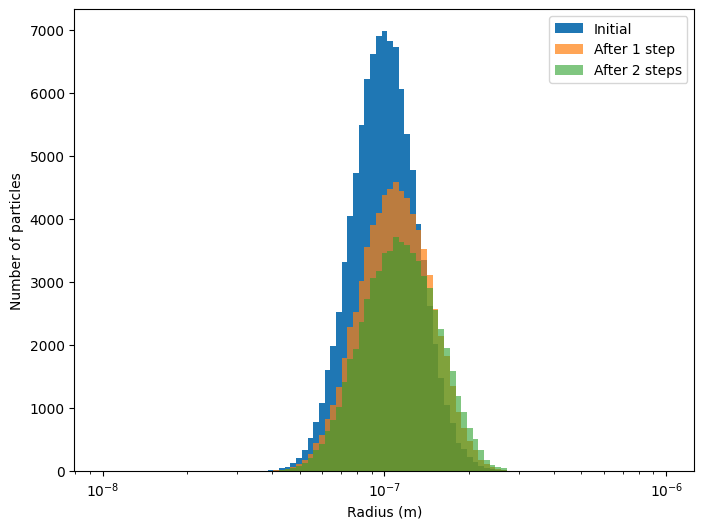

In [4]:
# Create figure for visualizing the histogram of particle radii
fig, ax = plt.subplots(figsize=(8, 6))

# Plot initial radii distribution
bins, edges = np.histogram(initial_radii, bins=bins_lognormal)
ax.bar(edges[:-1], bins, width=np.diff(edges), align="edge", label="Initial")

# Plot radii distribution after step 1
bins, edges = np.histogram(radii_after_step_1, bins=bins_lognormal)
ax.bar(
    edges[:-1],
    bins,
    width=np.diff(edges),
    align="edge",
    label="After 1 step",
    alpha=0.7,
)

# Plot radii distribution after step 2
bins, edges = np.histogram(radii_after_step_2, bins=bins_lognormal)
ax.bar(
    edges[:-1],
    bins,
    width=np.diff(edges),
    align="edge",
    label="After 2 steps",
    alpha=0.6,
)

# Set axes to logarithmic scale for x-axis (particle radius)
ax.set_xscale("log")

# Add labels and legend
ax.set_xlabel("Radius (m)")
ax.set_ylabel("Number of particles")
plt.legend()

# Show the plot
plt.show()

## Conclusion

In this notebook, we have demonstrated a particle-resolved approach to modeling coagulation patterns in aerosol systems. By leveraging the `Builder` pattern and modular design, we have created a flexible and extensible framework for simulating particle interactions and tracking their properties over time.